# Part II - Use of Bikes From Ford GoBike Sharing System
## by Hichem Dridi

## Investigation Overview

In this investigation, I did a descriptive analysis on the journeys made by the bikes of the Ford GoBike Sharing System. Emphasis was placed on the effect of days and times of the week on bicycle use and travel times.

## Dataset Overview

The original dataset we started with contains information on 183,412 bike trips divided into 16 different columns that describe trip time, stations, date, user, and more. With some cleanup and feature engineering, that number of columns grew to 22, I've only kept 14 for the analysis part.

In [1]:
!pip install folium
!pip install squarify

    100% |████████████████████████████████| 102kB 4.9MB/s a 0:00:011


In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium
import squarify

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
bikes_df = pd.read_csv('201902-fordgobike-tripdata-clean.csv')
orig_bikes_df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [4]:
# convert start_day, end_day and member_age_grouped into ordered categorical types
ordinal_var_dict = {"start_day": ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                   "end_day": ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                   "member_age_grouped": ['Young', 'Mid-Aged', 'Old']
                   }

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                               categories = ordinal_var_dict[var])
    bikes_df[var] = bikes_df[var].astype(ordered_var)

## Users of the Bike Sharing System

The bikes made available by this system are mostly used by subscribers, it is quite understandable that people who frequently use these bikes tend to subscribe. It's also quite remarkable that men are the sex that uses this bike-sharing system more than others. Young people also seem to prefer this transport tool.

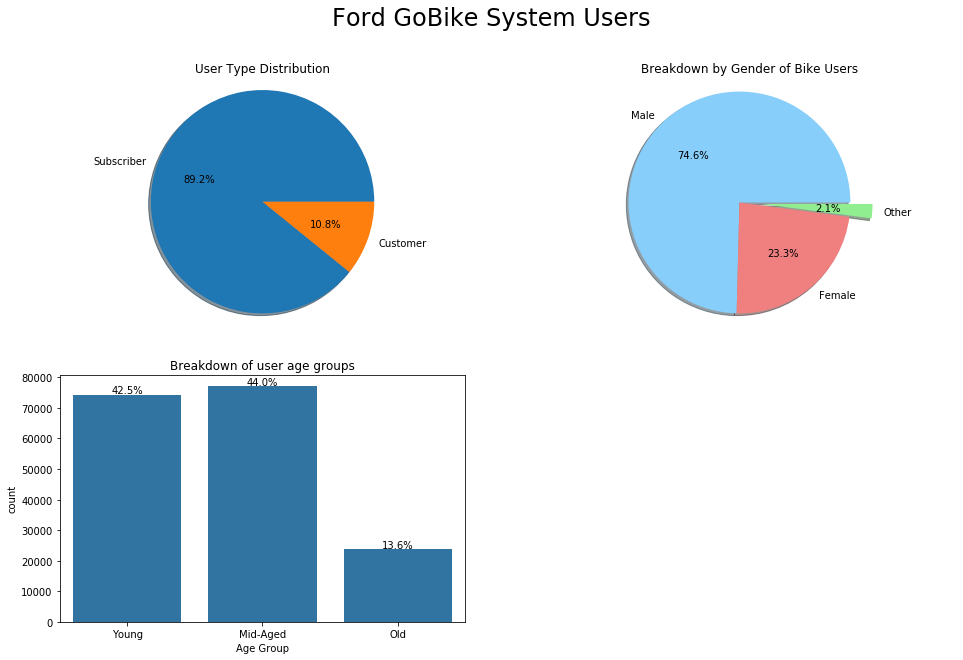

In [5]:
fig = plt.figure(figsize = (16, 10))

# plot user type distribution
ax1 = fig.add_subplot(221)
bikes_df.user_type.value_counts().plot(kind = 'pie',
                                      autopct = '%1.1f%%',
                                      shadow = True,
                                      ax = ax1)
ax1.axis('equal')
ax1.set(ylabel = '', title = 'User Type Distribution')

# plot gender distribution
ax2 = fig.add_subplot(222)
bikes_df.member_gender.value_counts().plot(kind = 'pie',
                                      autopct = '%1.1f%%',
                                      shadow = True,
                                      explode = [0, 0, 0.2],
                                      colors = [ 'lightskyblue', 'lightcoral', 'lightgreen'],
                                      ax = ax2)
ax2.axis('equal')
ax2.set(ylabel = '', title = 'Breakdown by Gender of Bike Users')

# plot age groups
ax3 = fig.add_subplot(223)
sb.countplot(data = bikes_df, x = 'member_age_grouped',
            color = sb.color_palette()[0],
            ax = ax3)

age_counts = bikes_df.member_age_grouped.value_counts()
for i in range(age_counts.shape[0]):
    count = age_counts[i]
    pct_string = '{:0.1f}%'.format(100 * count / age_counts.sum())
    plt.text(i, count + 500, pct_string, ha = 'center')
    
ax3.set(xlabel = 'Age Group', title = 'Breakdown of user age groups')

plt.suptitle('Ford GoBike System Users', fontsize = 24)
plt.show()

## The Stations

The data was collected during the month of February in the San Francisco Bay Area, the stations are distributed in the cities of San Francisco, Berkeley, Oakland, Emeryville, San Jose and Piedmont.

In [6]:
# clean the data form inaccurate values of latitudes and longitudes
missing_data_mask = orig_bikes_df.start_station_id.isnull()
columns_to_change = ['start_station_latitude', 'start_station_longitude',
                    'end_station_latitude', 'end_station_longitude']

orig_bikes_df.loc[missing_data_mask, columns_to_change] = np.nan

In [7]:
# get unique data for each station
stations_data = orig_bikes_df.groupby('start_station_name', as_index = False).first()
stations_data = stations_data[['start_station_name', 'start_station_latitude', 'start_station_longitude']]

labels = stations_data.start_station_name
latitudes = stations_data.start_station_latitude
longitudes = stations_data.start_station_longitude

# create San Francisco map
sanfran_map = folium.Map(location = (37.80, -122.35), zoom_start = 12)

# loop through the 329 stations and add each to the stations feature group
for lat, lng, label in zip (latitudes, longitudes, labels):
    folium.features.CircleMarker(
        [lat, lng],
        radius = 5,
        color = 'yellow',
        fill = True,
        popup = label,
        fill_color = 'blue',
        fill_opacity = 0.6
    ).add_to(sanfran_map)

sanfran_map

Among the cities mentioned above, San Francisco is the city with the highest number of bicycles used during this period:

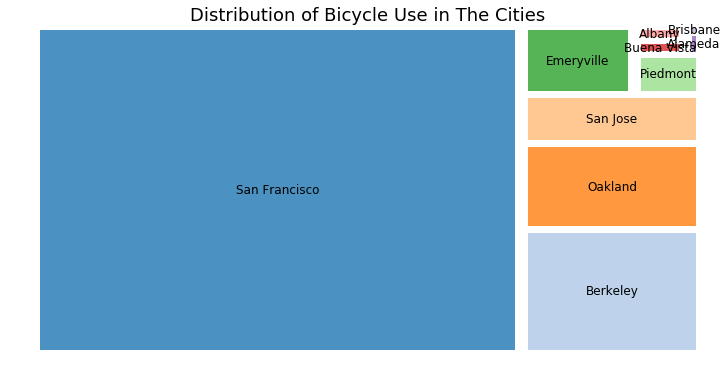

In [8]:
plt.figure(figsize = (12, 6))

start_cities_counts = bikes_df['start_city'].value_counts()

squarify.plot(sizes = start_cities_counts,
              label = start_cities_counts.index, 
              color = sb.color_palette("tab20", len(start_cities_counts)),
              pad = 1,
              alpha=.8,
             text_kwargs={'fontsize': 12})
plt.axis('off')
plt.title('Distribution of Bicycle Use in The Cities', fontsize = 18)
plt.show()

## Distribution of Trips Duration

The duration of trips in the dataset takes a very wide range of values, from about a minute to almost a day. Plotted on a logarithmic scale, the distribution of bike rides duration appears normal with a peak around 10 minutes.

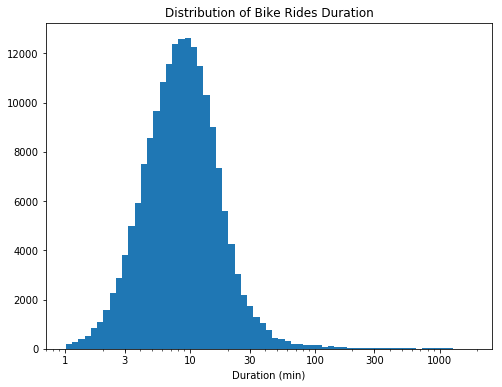

In [9]:
bins = 10**np.arange(0.007, 3.16 + 0.1, 0.05)

plt.figure(figsize = (8, 6))

plt.hist(data = bikes_df, x = 'duration_min', bins = bins)

plt.xscale('log')
xticks = [1, 3, 10, 30, 100, 300, 1000]
plt.xticks(xticks, xticks)

plt.title('Distribution of Bike Rides Duration')
plt.xlabel('Duration (min)')
plt.show()

## The Effect of Day and Time

I was interested in the evolution of hourly and daily bicycle use. Weekdays and times when people tend to commute from home to work and vice versa had the highest use of bicycles. On the other side, weekeends have the greatest average bike rides duration, especially in the middle of the day.

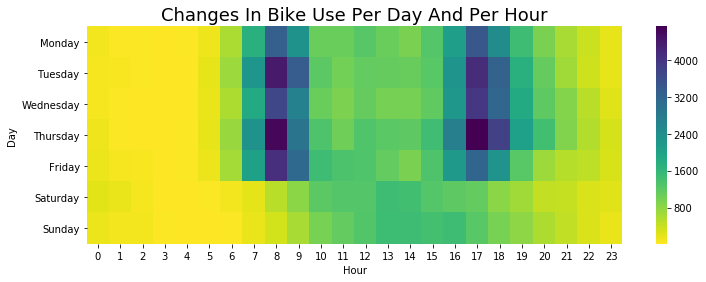

In [10]:
# create a pivot table with the bikes count for each hour-day combination
temp = bikes_df.groupby(['start_hour', 'start_day']).size()
temp = temp.reset_index().pivot(index = 'start_day', columns = 'start_hour')
temp.columns = temp.columns.droplevel()

# plot a hatmap
plt.figure(figsize = (12, 4))
sb.heatmap(temp, cmap = 'viridis_r')
plt.title("Changes In Bike Use Per Day And Per Hour", fontsize = 18)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.show()

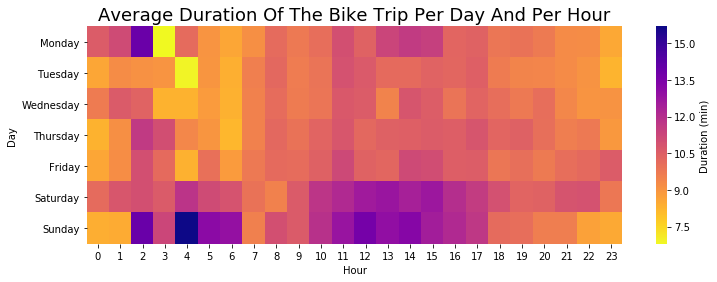

In [13]:
# select rows with duration equal or less to 1 hour
less60_df = bikes_df.query("duration_min <= 60")

# create a pivot table with the average ride durationfor each hour-day combination
temp = less60_df.groupby(['start_hour', 'start_day'])[['duration_min']].mean()
temp = temp.reset_index().pivot(index = 'start_day', columns = 'start_hour')
temp.columns = temp.columns.droplevel()

# plot a heatmap
plt.figure(figsize = (12, 4))
sb.heatmap(temp, cmap = 'plasma_r', cbar_kws={'label': 'Duration (min)'})
plt.title("Average Duration Of The Bike Trip Per Day And Per Hour", fontsize = 18)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.show()

## Who Rides The Longest?

With only three user-related features to investigate, the trend I found is that customers tend to cycle for longer periods of time than subscribers. In contrast, men tend to make shorter journeys in all three age categories.

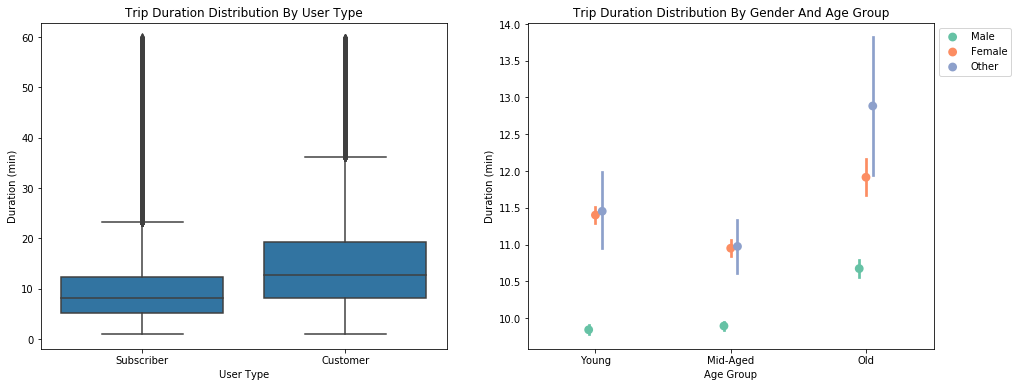

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

sb.boxplot(data = less60_df, 
           x = 'user_type', 
           y = 'duration_min', 
           ax = ax[0], 
           color = sb.color_palette()[0]
          )
ax[0].set(xlabel = 'User Type', ylabel = 'Duration (min)',
         title = 'Trip Duration Distribution By User Type')

sb.pointplot(data = less60_df, 
             x = 'member_age_grouped', 
             y = 'duration_min', 
             hue = 'member_gender',
             palette = 'Set2', 
             linestyles = '', 
             dodge = 0.1, 
             ax  = ax[1]
            )
ax[1].set(xlabel = 'Age Group', ylabel = 'Duration (min)',
         title = 'Trip Duration Distribution By Gender And Age Group')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Generate Slideshow

In [19]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck.ipynb to slides
[NbConvertApp] Writing 884072 bytes to Part_II_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not 